In this notebook we are workiing on the same linear regression problem as before, and with the same input data, but this time, we are going to utilize PyTorch support.
The key takeaways are Technical:
1. Get familiar with the abstractions that PyTorch provide: ... 


In [1]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import helpers as h
from math import floor, ceil

In [2]:
torch.manual_seed(42)

### Setting the Data

In [3]:
NUMBER_OF_DATA_POINTS = 4
X_RANGE = {
    'min': 0,
    'max': 2
}
SLOPE = 3
INTERCEPT = 4
NOISE_RANGE = 1.5
m = NUMBER_OF_DATA_POINTS  # number of instances (the number of data-points)

def generate_data(
    x_range:dict[str, str]=X_RANGE,
    number_of_data_points:int=NUMBER_OF_DATA_POINTS,
    slope:float=SLOPE,
    intercept:float=INTERCEPT,
    noise_range:float=NOISE_RANGE
    ) -> tuple[torch.Tensor, torch.Tensor]:
    """
    Generates data for linear regression.
    """
    range = X_RANGE['max'] - X_RANGE['min']
    X = x_range['min'] + (range * torch.rand(size=(number_of_data_points, 1)))  # randomly-generated x-values, taken from a uniform distribution within `x_range`
    y = intercept + (slope * X) + (((torch.rand(size=(number_of_data_points, 1)) - 0.5) * 2) * noise_range)  # y-values with uniformaliy distributed noise added
    return X, y

def calculate_y_range(
    x_range:dict[str, str]=X_RANGE,
    slope:float=SLOPE,
    intercept:float=INTERCEPT,
    noise_range:float=NOISE_RANGE,
    ) -> float:
    """
    Calculates the maximum y-value for a given x-range, taking into account the maximum noise.
    """
    y_range = {}
    if slope >= 0:
        y_range['min'] = intercept + (slope * x_range['min']) - noise_range
        y_range['max'] = intercept + (slope * x_range['max']) + noise_range
    elif slope < 0:
        y_range['min'] = intercept + (slope * x_range['min']) + noise_range
        y_range['max'] = intercept + (slope * x_range['max']) - noise_range
    return y_range

X, y = generate_data()
y_range = calculate_y_range()

In [4]:
h.print_tensor_info(X, fields=['Tensor', 'Dimension', 'Shape'])

Tensor       tensor([[1.7645],
        [1.8300],
        [0.7657],
        [1.9186]])
Dimension    2
Shape        (4, 1)


The many PyTorch (and Tensorflow) functions expect their input to be in the shape of (batch_size, features). Note that above `X` was defined accordingly. The number of data points (also called instances), is generally always in the 0th dimension. 

In [5]:
h.print_tensor_info(y, fields=['Tensor', 'Dimension', 'Shape'])

Tensor       tensor([[ 8.9650],
        [ 9.7927],
        [ 5.5669],
        [10.6368]])
Dimension    2
Shape        (4, 1)


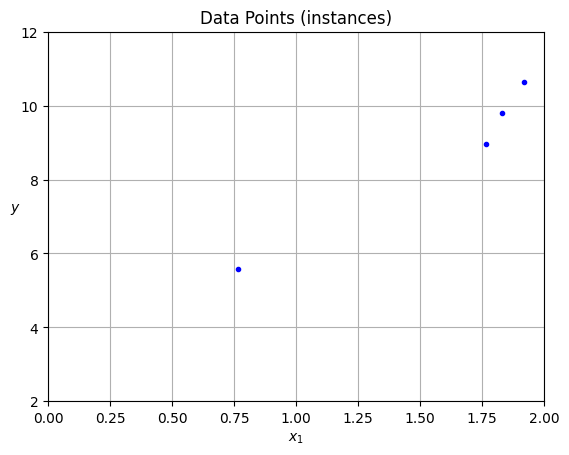

In [6]:
def plot_data_points(X, y):
    plt.plot(X, y.detach().numpy(), "b.")
    plt.xlabel("$x_1$")
    plt.ylabel("$y$", rotation=0)
    plt.title("Data Points (instances)")
    plt.axis([X_RANGE['min'], X_RANGE['max'], floor(y_range['min']), ceil(y_range['max'])])
    plt.grid()
    plt.show()
    return

plot_data_points(X, y)

### Preprocessing the Data

Now we are adding a dummy input parameter, that is equal to one for all instances: $x_0=1$.
This will allow us to use a single matrix multiplication for the equation $y =  w_0*1 + w_1*x_1$. It  is the genric form of a 1-dimensional linear equation. 

(for additional optional context, see: [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.add_dummy_feature.html))

In [7]:
X_extended = torch.cat((torch.full(X.shape, 1), X), 1)

In [8]:
h.print_tensor_info(X_extended, fields=['Tensor', 'Dimension', 'Shape'])

Tensor       tensor([[1.0000, 1.7645],
        [1.0000, 1.8300],
        [1.0000, 0.7657],
        [1.0000, 1.9186]])
Dimension    2
Shape        (4, 2)


### Defining the Model
With this form of input we can define the parameters: $w_0$ and $w_1$.
The equation is $y = w_0*x_0 + w_1*x_1$, or in a matrix notation: $y = X @ W$.
It might be helpful to write with PyTorch. 

In [9]:
def model(X, W):
    return X @ W

Let's assign values for our parameters, $W$

In [10]:
W = torch.tensor([[1.], [2.]], requires_grad=True)  # usually the parameters are randmoly set
# TODO change the above to a random initialization, and see what happens.
# Then change it to a zero initialization, and see what happens.
# Lastly, try setting it to the mean of the y values, with zero slope.

In [11]:
h.print_tensor_info(W, fields=['Tensor', 'Dimension', 'Shape'])

Tensor       tensor([[1.],
        [2.]], requires_grad=True)
Dimension    2
Shape        (2, 1)


In [12]:
def predict(X: torch.Tensor, W: torch.Tensor, is_preprocessed=False) -> torch.Tensor:
    """
    Calculates the value of a linear function with parameters W at points X.

    X: torch tensor of shape (number_of_points_to_predict, 1)
    W: torch tensor of shape (2, 1)
    return: torch tensor of shape (number_of_points_to_predict, 1)

    """
    if is_preprocessed:
        X_extended = X
    else:
        X_extended = torch.cat((torch.full(X.shape, 1), X), 1)  # preprocess
    y_predicted = model(X_extended, W)
    return y_predicted

In [13]:
y_predicted = predict(X_extended, W, is_preprocessed=True)

In [14]:
h.print_tensor_info(y_predicted, fields=['Tensor', 'Dimension', 'Shape'])

Tensor       tensor([[4.5291],
        [4.6600],
        [2.5315],
        [4.8372]], grad_fn=<MmBackward0>)
Dimension    2
Shape        (4, 1)


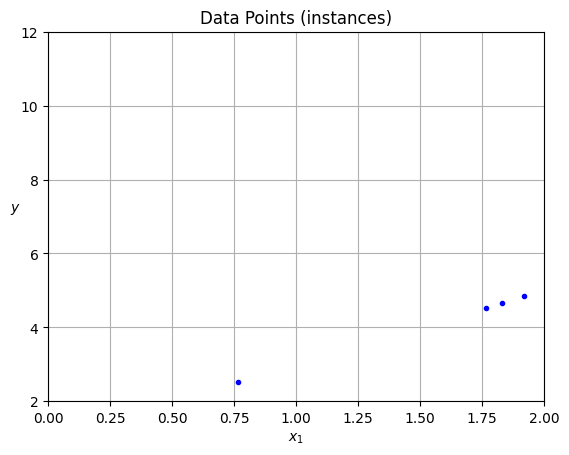

In [15]:
plot_data_points(X, y_predicted)

### Setting up a Loss Function
We need to define a cost-function - which is the value to be optimized.
First let's plot the data points and the predictions on the same graph: 

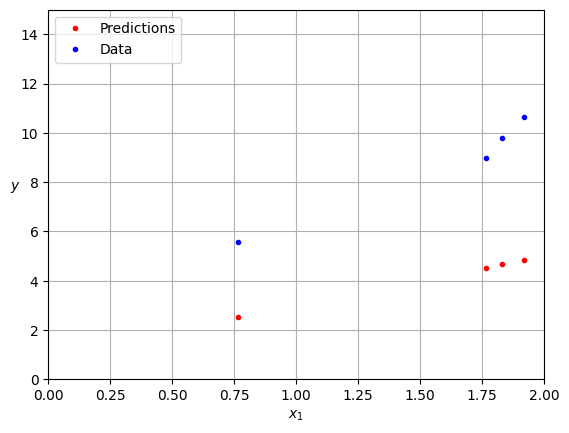

In [16]:
# TODO fix - there is no red line on the plot
plt.plot(X, y_predicted.detach().numpy(), "r.", label="Predictions")
plt.plot(X, y, "b.", label="Data")

plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid()
plt.legend(loc="upper left")

plt.show()

The loss function we are going to use is the squared mean error (SME):

$\frac{1}{m}*\sum_{n=1} ^{m} (y_{predicted, n} - y_n)^2$

In [17]:
def loss_fn(y_predicted, y):
    sme = ((y_predicted - y) ** 2).mean()  # squared mean error. This is equivalent to: torch.sum((y_predicted - y)**2)/y.numel()
    return sme

In [18]:
# First, demonstrating the calculation of the loss for each instance:
print('Squared error per instance:')
print((y_predicted - y)**2)

Squared error per instance:
tensor([[19.6771],
        [26.3445],
        [ 9.2139],
        [33.6346]], grad_fn=<PowBackward0>)


In [19]:
sme = torch.sum((y_predicted - y)**2)/y.numel()
print(f'SME: {sme:.4}')

SME: 22.22


In [20]:
loss = loss_fn(y_predicted, y)
sme = loss
print(f'SME: {sme:.4}')

SME: 22.22


### Optimization
Instead of defining the gradient ourselves by analytically deriving two partial derivatives as in the previous notebook, here we use PyTorch's automatic gradient calculation. 

In [47]:
lr = 0.02
print(f'Learning Rate: {lr:.4}')

Learning Rate: 0.05


In [48]:
optimizer = optim.SGD([W], lr=lr)

In [49]:
loss

tensor(6.4524, grad_fn=<MeanBackward0>)

In [24]:
y_predicted

tensor([[4.5291],
        [4.6600],
        [2.5315],
        [4.8372]], grad_fn=<MmBackward0>)

Before we run the gradient iteratively, let's run the first iteration, and take a look at the value of the parameters, its graphical reporesentation, 

In [25]:
loss.backward()

In [26]:
loss

tensor(22.2175, grad_fn=<MeanBackward0>)

In [27]:
W

tensor([[1.],
        [2.]], requires_grad=True)

In [28]:
W.grad

tensor([[ -9.2018],
        [-15.3358]])

In [29]:
optimizer.step()

In [30]:
print(W)
print(W.grad)

tensor([[1.1840],
        [2.3067]], requires_grad=True)
tensor([[ -9.2018],
        [-15.3358]])


In [38]:
# If we were to skip the gradient reset to zero, gradients will be accumulated across multiple iterations.
# This is not what we want, as we want to calculate the gradient for each iteration seperatly.
# Notice that here we redefine y_predicted and loss, try running the code without the redefinition and see what happens.

optimizer.zero_grad()
y_predicted = model(X_extended, W)  # redefining y_predicted
loss = loss_fn(y_predicted, y)  # redefining loss
loss.backward()
optimizer.step()

In [39]:
print(W)
print(W.grad)

tensor([[1.6898],
        [3.1488]], requires_grad=True)
tensor([[-4.9271],
        [-8.1955]])


Now we can run the optimization iteratively. 
We can save the values of the parameters, and the loss. We can also plot them. 

In [44]:
def training_loop(n_epochs, optimizer, W, X, y):
    for epoch in range(1, n_epochs + 1):
        y_predicted = model(X, W) 
        loss = loss_fn(y_predicted, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 50 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            
    return W

In [51]:
W = training_loop(n_epochs=500, optimizer=optimizer, W=W, X=X_extended, y=y)

Epoch 50, Loss 0.139749
Epoch 100, Loss 0.139749
Epoch 150, Loss 0.139748
Epoch 200, Loss 0.139748
Epoch 250, Loss 0.139748
Epoch 300, Loss 0.139749
Epoch 350, Loss 0.139748
Epoch 400, Loss 0.139749
Epoch 450, Loss 0.139749
Epoch 500, Loss 0.139749


In [55]:
W

tensor([[2.3978],
        [4.0406]], requires_grad=True)

In [56]:
y_predicted = model(X_extended, W)

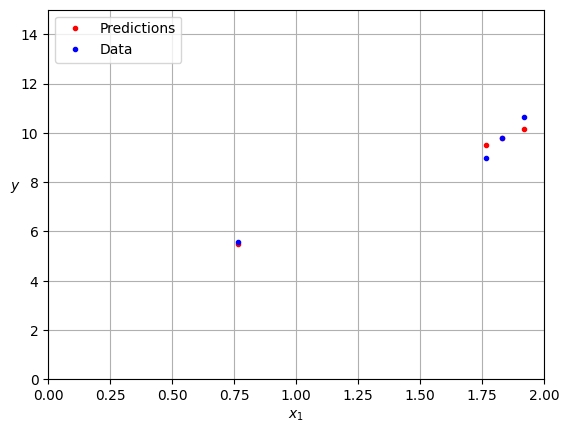

In [57]:
# TODO fix - there is no red line on the plot
plt.plot(X, y_predicted.detach().numpy(), "r.", label="Predictions")
plt.plot(X, y, "b.", label="Data")

plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid()
plt.legend(loc="upper left")

plt.show()